# Dark Sky Positions direct from Catalogue

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits

import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

from dl import queryClient as qc
import pandas as pd

/Users/vernica/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Querying tractor catalogue for one degree squares

In [2]:
def query_tractor(ra_b, dec_b, dist=1.0):
    """Queries the Astro Data Lab for the ra, dec and mag_g of the objects within a square of side length (dist).     
    dist is in degrees
    """
    # Bounds of the square we are querying objects for
    ra_min=ra_b
    ra_max = ra_b + dist
    dec_min=dec_b
    dec_max = dec_b + dist

    query = f"""
    SELECT ra, dec, mag_g
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g <= 21 AND mag_g >= 16
    """
    
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info, [ra_min, ra_max, dec_min, dec_max]

tractor_df, coords = query_tractor(0, 0)

In [3]:
# masking for low magnitude objects

def mask_radius(fov_radius=20):
    radius = (fov_radius/3600) + 1630./3600. * 1.396**(-tractor_df['mag_g'])
    tractor_df['radius'] = radius
    return tractor_df

mask_radius()

,ra,dec,mag_g,radius
0,0.078990,0.013123,20.010588,0.006127
1,0.078851,0.105726,19.390509,0.006258
2,0.205316,0.028401,20.625372,0.006021
3,0.193515,0.067243,20.240402,0.006084
4,0.208100,0.057905,18.617342,0.006464
...,...,...,...,...
3045,0.991848,0.977234,20.104015,0.006109
3046,0.956724,0.991512,17.527546,0.006863
3047,0.965541,0.991770,18.387604,0.006537
3048,0.984671,0.979338,20.796118,0.005995


## Get bitmask info

Positions and masking radius for stars with magnitudes <16 are listed in the `mask_data_[N].npz` files. Each index is a different range of DEC:

| index | (DEC1, DEC2) |
| ----- | ----------- | 
| 0 | (-90, -66) |
| 1 | (-66, -42) |
| 2 | (-42, -18) |
| 3 | (-18, 6) |
| 4 | (6, 30) |

In [122]:
def load_mask_data(index=0, load_all=False):
    """Load a desired mask data file by index, or just download all five. 
    Returns a pandas Dataframe with columns 'ra', 'dec', 'radius'
    """
    
    # load all
    if load_all:
        all_masks = []
        for i in range(5):
            
            with np.load(f"mask_data_{i}.npz", mmap_mode='r') as mask_data:
                mask_array = mask_data['arr_0']
                mask_array_byteswap = mask_array.byteswap().newbyteorder()
                masked_stars = pd.DataFrame(mask_array_byteswap)
                all_masks.append(masked_stars)
        return pd.concat(all_masks, ignore_index=True)

    # load single index
    with np.load(f"mask_data_{index}.npz", mmap_mode='r') as mask_data:
        mask_array = mask_data['arr_0']
        mask_array_byteswap = mask_array.byteswap().newbyteorder()
        masked_stars = pd.DataFrame(mask_array_byteswap)

    return masked_stars
        
masked_stars = load_mask_data(load_all=True)
    

In [123]:
masked_stars

,ra,dec,radius
0,90.172277,-66.053705,0.012262
1,89.994336,-66.102438,0.010412
2,89.961793,-66.015076,0.008367
3,90.243334,-66.067733,0.007265
4,90.122942,-66.019305,0.005788
...,...,...,...
19204371,231.941317,6.072278,0.002702
19204372,231.850394,6.028061,0.002686
19204373,231.856376,6.113636,0.002609
19204374,231.755958,6.051862,0.002419


In [105]:
# you can "query" the dataframe as you need
masked_stars.query('(0.0 < ra < 1.0) & (-90.0 < dec < -89.0)')

,ra,dec,radius
2132979,0.398024,-89.286616,0.003989
2132986,0.492577,-89.325364,0.003762
2132987,0.189580,-89.243891,0.003582
2132994,0.548044,-89.205598,0.003119
2132995,0.409450,-89.196494,0.003093
2134025,0.337313,-89.481089,0.010508
2134912,0.344145,-89.657696,0.002204


## Segmentation map

Start with OG seg map, without bitmask stuff yet

In [34]:
def full_df():
    one_deg_sq = all_masks.query(' (ra >' + str(coords[0]) + ') & (ra <' + str(coords[1]) + ') & (dec >' + str(coords[2]) + ') & (dec <' + str(coords[3]) + ')' )
    df = pd.concat([tractor_df,one_deg_sq], axis=0)
    return df
df = full_df()

## Segmentation map

In [14]:
def seg_map():

    dim = 3600*4
    array = np.zeros((dim, dim), dtype=int)

    ra_pix = np.round(df['ra']*dim).astype(int) - 1
    dec_pix = np.round(df['dec']*dim).astype(int) - 1
    rad_pix = np.ceil(df['radius']*dim).astype(int)

    for y, x, r in zip(ra_pix,dec_pix,rad_pix):
        ra_max = x + r if x+r <= dim else dim
        ra_min = x - r if x-r >= 0 else 0
        dec_max = y + r if y+r <= dim else dim
        dec_min = y - r if y-r >= 0 else 0

        for i in range(ra_min,ra_max):
            for j in range(dec_min,dec_max):
                if ((i-x)**2 + (j-y)**2) <= r**2:
                    array[i,j] = 1

    return array, [ra_pix, dec_pix, rad_pix]

array, pix_coords = seg_map()

In [29]:
def define_grid(fov=45):
    
    gridlines = np.arange(0, 3600*4+1, (fov*4))
    return gridlines

gridlines = define_grid()
gridlines

array([    0,   180,   360,   540,   720,   900,  1080,  1260,  1440,
        1620,  1800,  1980,  2160,  2340,  2520,  2700,  2880,  3060,
        3240,  3420,  3600,  3780,  3960,  4140,  4320,  4500,  4680,
        4860,  5040,  5220,  5400,  5580,  5760,  5940,  6120,  6300,
        6480,  6660,  6840,  7020,  7200,  7380,  7560,  7740,  7920,
        8100,  8280,  8460,  8640,  8820,  9000,  9180,  9360,  9540,
        9720,  9900, 10080, 10260, 10440, 10620, 10800, 10980, 11160,
       11340, 11520, 11700, 11880, 12060, 12240, 12420, 12600, 12780,
       12960, 13140, 13320, 13500, 13680, 13860, 14040, 14220, 14400])

In [31]:
def find_dark_regions():

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = (gridlines[i]).astype(int), (gridlines[i + 1]).astype(int)
            y_start, y_end = (gridlines[j]).astype(int), (gridlines[j + 1]).astype(int)
            
            if np.all(array[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans

dr_trans = find_dark_regions()

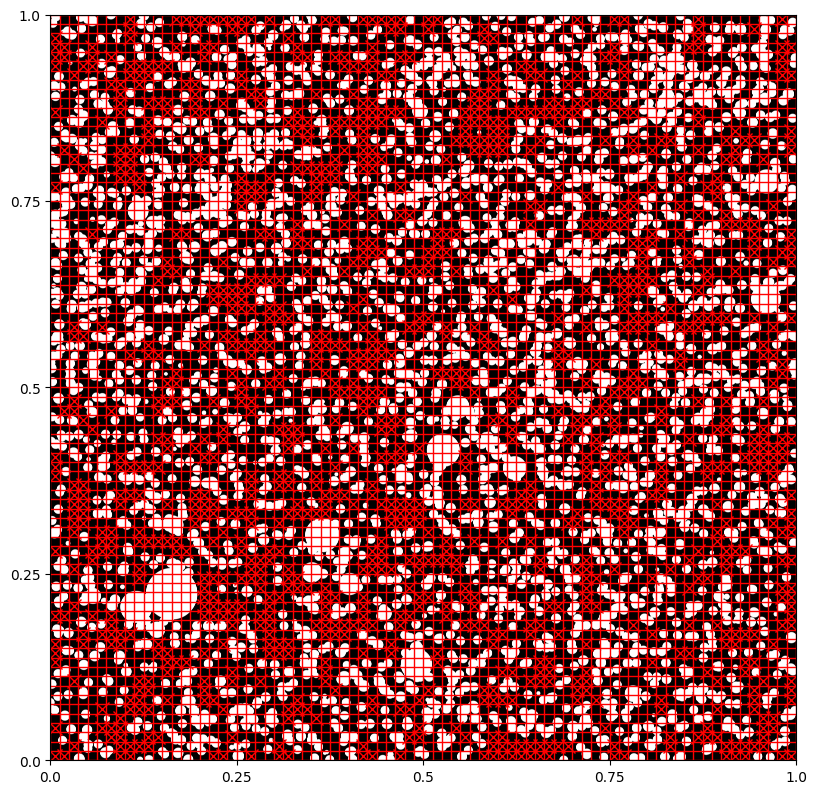

In [32]:
def create_plot():

    # Creating exclusion map with grid
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.imshow(array, origin = 'lower', cmap='gray', vmin=0, vmax=1)

    positions = np.linspace(0,3600*4,5)
    labels = np.linspace(coords[0],coords[1],5)

    ax.set_xticks(positions, labels)
    ax.set_yticks(positions, labels)    

    plt.vlines(gridlines, min(pix_coords[1]), max(pix_coords[1]), color='red', linewidth=1)
    plt.hlines(gridlines, min(pix_coords[0]), max(pix_coords[0]), color= 'red', linewidth=1)

    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)

    plt.tight_layout()
    plt.margins(0)
    plt.show()

    return

create_plot()

In [51]:
len(dr_trans[0])

1047